主題 : 預測泰坦尼克號倖存者預測

In [3]:
import pandas as pd
import numpy as np

In [4]:
#先將訓練集跟測試集都載入
train = pd.read_csv('train.csv',sep = ',')
test = pd.read_csv('test.csv', sep = ',')

In [5]:
#為了避免兩個資料集有欄未或格式上有所不同，因此要先將兩個資料集合併後，做資料清洗
#因為訓練集有survived欄位，而測試集沒有，做探索性分析時，主要會用到訓練集的資料來做分析
#為了能區分訓練集跟測試集，所以要先增加is_train欄位(0 = 測試集，1 = 訓練集)
#在做完資料清洗後，再利用 is_train 這欄，來將訓練集跟測試集分開
#而測試集沒有survived欄位，所以要新增一個給他，但欄位值會是用nan來代替
train['is_train'] = 1
test['is_train'] = 0
test['Survived'] = np.nan
# pd.concat()會保留合併前的索引排序，若不想保留，直接使用 ignore_index = True就可以讓合併後的索引接著排序
df_all = pd.concat([train,test],sort = False, ignore_index = True)

資料清洗

In [7]:
#刪除passenger ID，Name
df_all = df_all.drop(columns = ['PassengerId','Name'])
#增加家人欄位(兄弟姊妹+配偶+父母+小孩)
df_all['family_count'] = (df_all['SibSp'].fillna(0) + df_all['Parch'].fillna(0) )

# 年齡分群
#因為年齡有缺失值，所以會用年齡中位數來替代缺失值(年齡比較會有偏態的問題，所以用中位數替代)
df_all['Age'] = df_all['Age'].fillna(df_all['Age'].median())
age_group = [0,20,30,40,50,60,100]
labels = ['<20','20-29','30-39','40-49','50-59','>60']
df_all['age_group'] = pd.cut(df_all['Age'],bins = age_group , labels = labels)

#登陸港資料補齊(因為缺失值數量非常少，只有2筆，所以直接用眾數替代)
#將缺失的資料改為登陸港數量最多的'S'(Southampton)
most_port = df_all['Embarked'].mode()[0]
df_all['Embarked'] = df_all['Embarked'].fillna(most_port)
df_all

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train,family_count,age_group
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,20-29
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,30-39
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,20-29
3,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,1,1,30-39
4,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,0,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,28.0,0,0,A.5. 3236,8.0500,NaN,S,0,0,20-29
1305,NaN,1,female,39.0,0,0,PC 17758,108.9000,C105,C,0,0,30-39
1306,NaN,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,0,30-39
1307,NaN,3,male,28.0,0,0,359309,8.0500,NaN,S,0,0,20-29


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    float64 
 1   Pclass        1309 non-null   int64   
 2   Sex           1309 non-null   object  
 3   Age           1309 non-null   float64 
 4   SibSp         1309 non-null   int64   
 5   Parch         1309 non-null   int64   
 6   Ticket        1309 non-null   object  
 7   Fare          1308 non-null   float64 
 8   Cabin         295 non-null    object  
 9   Embarked      1309 non-null   object  
 10  is_train      1309 non-null   int64   
 11  family_count  1309 non-null   int64   
 12  age_group     1309 non-null   category
dtypes: category(1), float64(3), int64(5), object(4)
memory usage: 124.3+ KB


In [9]:
#將測試集跟訓練集分開
df_train = df_all[df_all['is_train'] == 1].copy()
df_test = df_all[df_all['is_train'] == 0].copy()

In [10]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train,family_count,age_group
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,20-29
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,30-39
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,20-29
3,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,1,1,30-39
4,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,0,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,male,27.0,0,0,211536,13.0000,NaN,S,1,0,20-29
887,1.0,1,female,19.0,0,0,112053,30.0000,B42,S,1,0,<20
888,0.0,3,female,28.0,1,2,W./C. 6607,23.4500,NaN,S,1,3,20-29
889,1.0,1,male,26.0,0,0,111369,30.0000,C148,C,1,0,20-29


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    float64 
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    object  
 3   Age           891 non-null    float64 
 4   SibSp         891 non-null    int64   
 5   Parch         891 non-null    int64   
 6   Ticket        891 non-null    object  
 7   Fare          891 non-null    float64 
 8   Cabin         204 non-null    object  
 9   Embarked      891 non-null    object  
 10  is_train      891 non-null    int64   
 11  family_count  891 non-null    int64   
 12  age_group     891 non-null    category
dtypes: category(1), float64(3), int64(5), object(4)
memory usage: 91.6+ KB


先做探索性分析
1.不同性別的倖存比例
2.不同年齡的倖存比例
3.不同登陸港的倖存比例
4.不同船艙的倖存比例
5.家人數不同的倖存比例(家人多寡是否影響倖存)

探索性分析

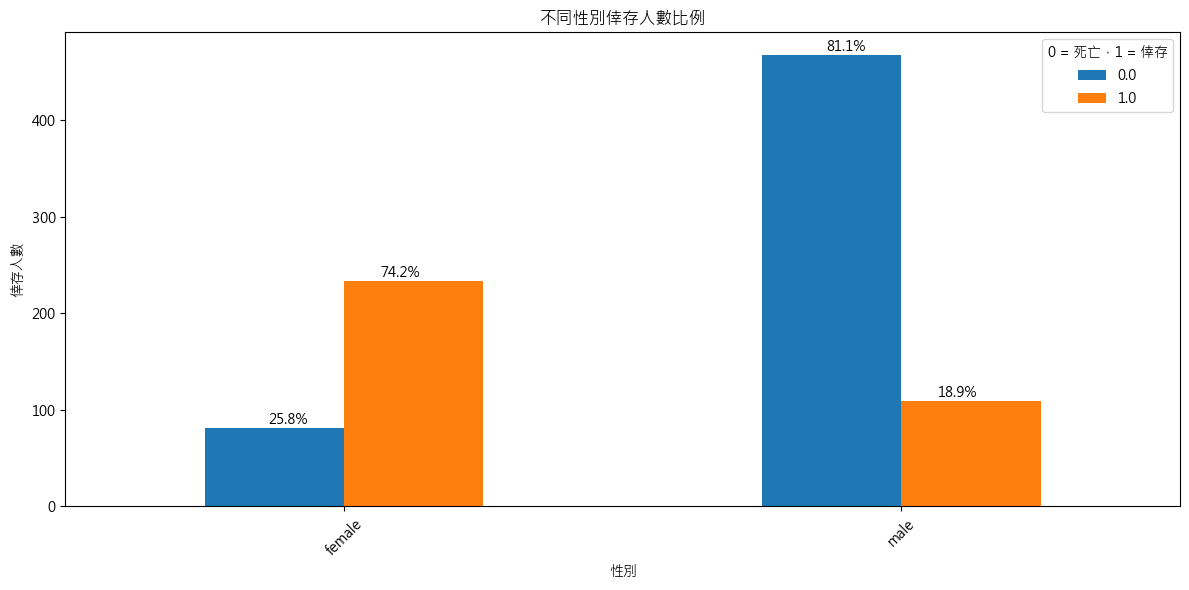

In [14]:
#畫出不同性別的倖存比例

from matplotlib import rcParams
# 設定中文字型
rcParams['font.family'] = ['Microsoft JhengHei', 'sans-serif']
# 使用正確的負號
rcParams['axes.unicode_minus'] = False
import seaborn as sns
import matplotlib.pyplot as plt

#計算不同性別的倖存比例並標註在長條圖上
sex_group = df_train.groupby(['Sex','Survived']).size().unstack(fill_value = 0)
ax = sex_group.plot(kind = 'bar' , stacked = False,figsize = (12,6))
rate = sex_group[1] /(sex_group[0]+sex_group[1])

for i ,(sex,rate) in enumerate(rate.items()):
    height = sex_group.loc[sex,1]
    ax.text(i + 0.1, height ,f'{rate:.1%}',ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
    death_height = sex_group.loc[sex,0]
    ax.text(i-0.1 ,death_height ,f'{1-rate:.1%}',ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
plt.title('不同性別倖存人數比例')
plt.xlabel('性別')
plt.ylabel('倖存人數')
plt.legend(title = '0 = 死亡，1 = 倖存')
plt.xticks(rotation = 45)
#plt.savefig('不同性別倖存人數比例',dpi = 300)
plt.tight_layout()
plt.show()

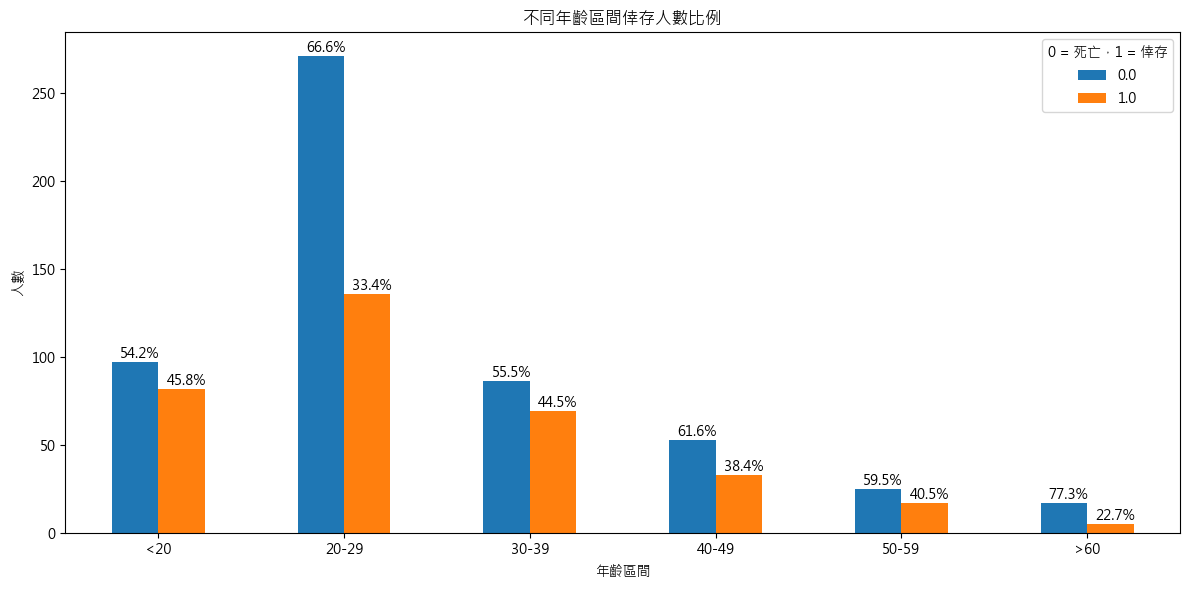

In [15]:
#畫出不同年齡區間倖存比例
from matplotlib import rcParams
# 設定中文字型
rcParams['font.family'] = ['Microsoft JhengHei', 'sans-serif']
# 使用正確的負號
rcParams['axes.unicode_minus'] = False
import seaborn as sns
import matplotlib.pyplot as plt

#計算不同年齡區間的人數比例
#當資料類型為category時，在做資料雙層分組時，增加 observed = True，能只顯示實際出現在資料中的組合
# observed = False ，保留所有可能的類別組合(ex.)
Age_group = df_train.groupby(['age_group','Survived'],observed = True).size().unstack(fill_value = 0)
ax = Age_group.plot(kind = 'bar',stacked = False,figsize = (12,6))
rate = Age_group[1] / (Age_group[0] + Age_group[1])

#將計算好的比例標住在柱子上
for i , (age_group,rate) in enumerate (rate.items()):
    s_height = Age_group.loc[age_group,1]
    ax.text(i + 0.15, s_height ,f'{rate:.1%}',ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
    d_height = Age_group.loc[age_group,0]
    ax.text(i - 0.1, d_height ,f'{1-rate:.1%}', ha = 'center', va = 'bottom',color = 'black',fontsize = 10 )
plt.title('不同年齡區間倖存人數比例')
plt.xlabel('年齡區間')
plt.ylabel('人數')
plt.legend(title = '0 = 死亡，1 = 倖存')
plt.xticks(rotation = 0)
#plt.savefig('不同年齡區間倖存人數比例',dpi = 300)
plt.tight_layout()
plt.show()

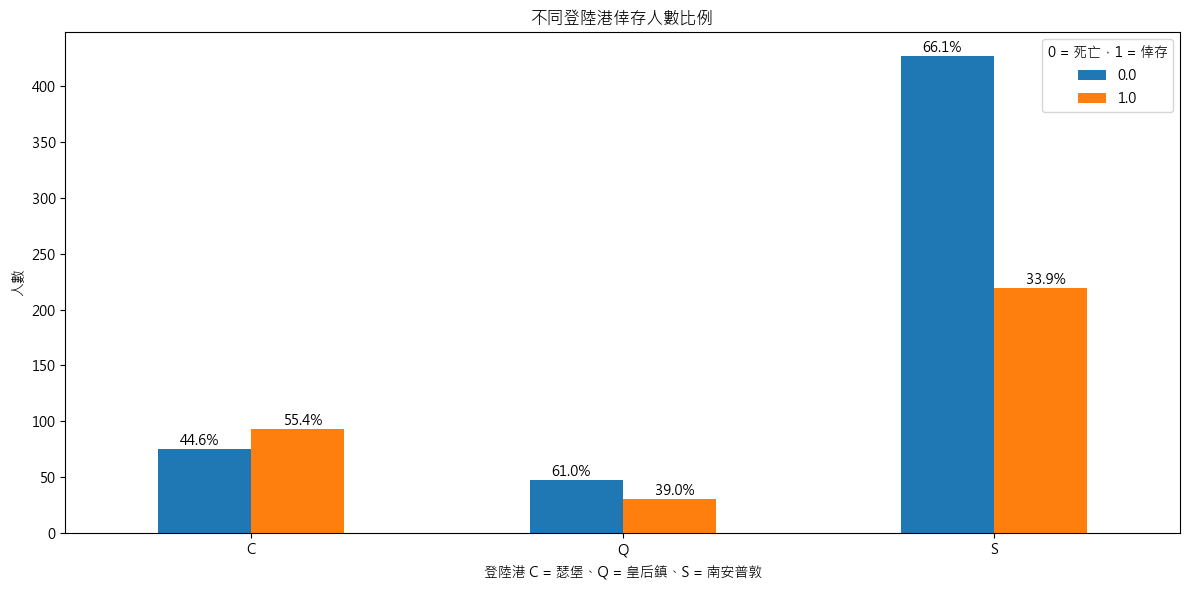

In [16]:
#畫出不同登陸港的倖存比例
from matplotlib import rcParams
# 設定中文字型
rcParams['font.family'] = ['Microsoft JhengHei', 'sans-serif']
# 使用正確的負號
rcParams['axes.unicode_minus'] = False
import seaborn as sns
import matplotlib.pyplot as plt
#計算不同登陸港倖存人數比例
embarked_group = df_train.groupby(['Embarked','Survived']).size().unstack(fill_value = 0)
ax = embarked_group.plot(kind = 'bar',stacked = False , figsize = (12,6))
rate = embarked_group[1] / (embarked_group[0] + embarked_group[1])

#將比例標註在柱子上
for i,(embarked,rate) in enumerate (rate.items()):
    s_height = embarked_group.loc[embarked,1]
    ax.text(i + 0.14, s_height , f'{rate:.1%}',ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
    d_height = embarked_group.loc[embarked,0]
    ax.text(i - 0.14, d_height, f'{1-rate:.1%}',ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
plt.title('不同登陸港倖存人數比例')
plt.xlabel('登陸港 C = 瑟堡、Q = 皇后鎮、S = 南安普敦')
plt.ylabel('人數')
plt.xticks(rotation = 0)
plt.legend(title = '0 = 死亡，1 = 倖存')
#plt.savefig('不同登陸港倖存人數比例',dpi = 300)
plt.tight_layout()
plt.show()

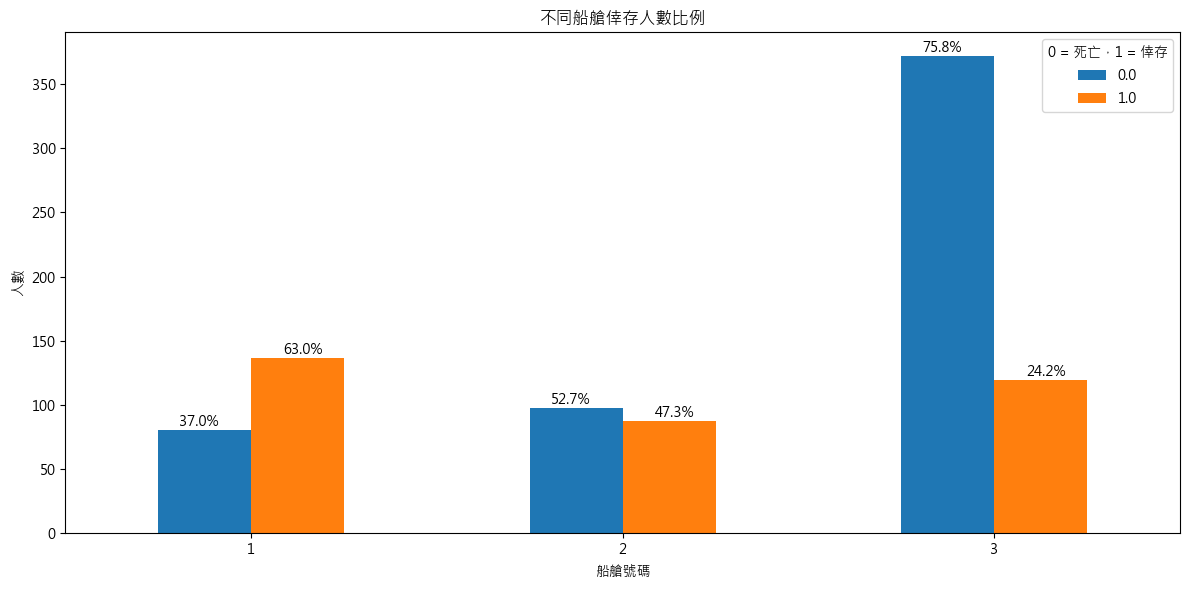

In [17]:
#不同船艙倖存比例
from matplotlib import rcParams
# 設定中文字型
rcParams['font.family'] = ['Microsoft JhengHei', 'sans-serif']
# 使用正確的負號
rcParams['axes.unicode_minus'] = False
import seaborn as sns
import matplotlib.pyplot as plt
#計算不同船艙倖存人數比例
pclass_group = df_train.groupby(['Pclass','Survived']).size().unstack(fill_value = 0)
ax = pclass_group.plot(kind = 'bar',stacked = False , figsize = (12,6))
rate = pclass_group[1] / (pclass_group[0] + pclass_group[1])
#將比例標註在柱子上
for i , (pclass,rate) in enumerate (rate.items()):
    s_height = pclass_group.loc[pclass,1]
    ax.text(i + 0.14 , s_height , f'{rate:.1%}', ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
    d_height = pclass_group.loc[pclass,0]
    ax.text(i - 0.14, d_height , f'{1-rate:.1%}',ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
plt.title('不同船艙倖存人數比例')
plt.xlabel('船艙號碼')
plt.ylabel('人數')
plt.xticks(rotation = 0)
plt.legend(title = '0 = 死亡，1 = 倖存')
#plt.savefig('不同船艙倖存人數比例',dpi = 300)
plt.tight_layout()
plt.show()

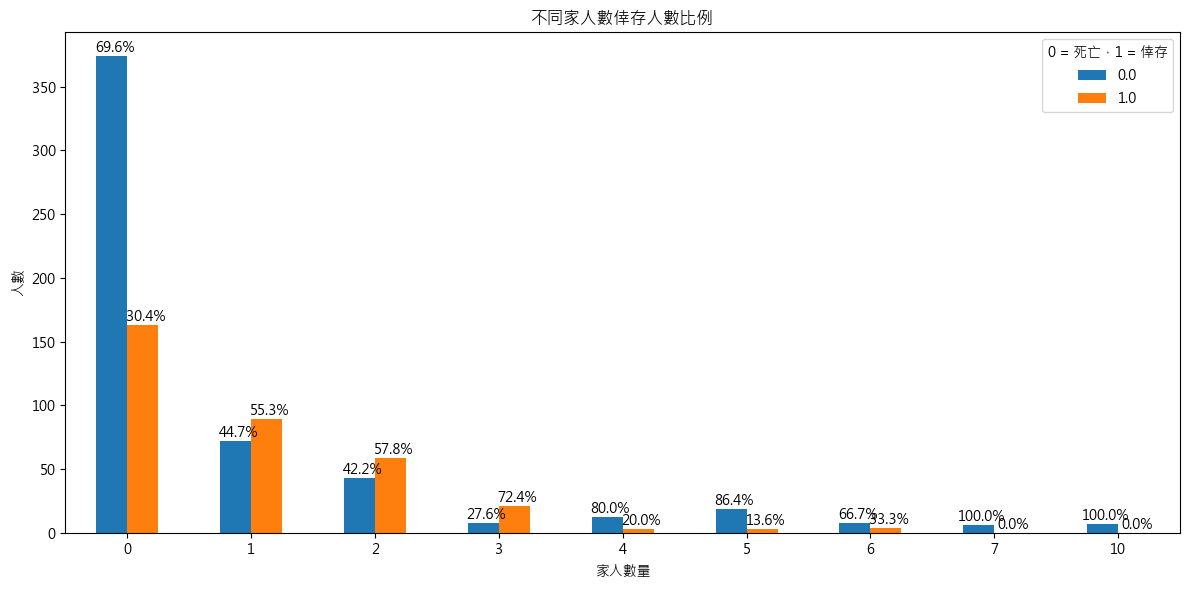

In [18]:
#家人數不同的倖存比例
from matplotlib import rcParams
# 設定中文字型
rcParams['font.family'] = ['Microsoft JhengHei', 'sans-serif']
# 使用正確的負號
rcParams['axes.unicode_minus'] = False
import seaborn as sns
import matplotlib.pyplot as plt
#計算不同家人數倖存人數比例
family_group = df_train.groupby(['family_count','Survived']).size().unstack(fill_value = 0)
ax = family_group.plot(kind = 'bar',stacked = False , figsize = (12,6))
rate = family_group[1] / (family_group[0] + family_group[1])
#將比例寫在柱子上
for i ,(family,rate) in enumerate (rate.items()):
    s_height = family_group.loc[family,1]
    ax.text(i + 0.15 , s_height , f'{rate:.1%}',ha = 'center',va = 'bottom',color = 'black',fontsize = 10)
    d_height = family_group.loc[family,0]
    ax.text(i - 0.1, d_height , f'{1-rate:.1%}' , ha = 'center', va = 'bottom', color = 'black', fontsize = 10)
plt.title('不同家人數倖存人數比例')
plt.xlabel('家人數量')
plt.ylabel('人數')
plt.xticks(rotation = 0)
plt.legend(title = '0 = 死亡，1 = 倖存')
#plt.savefig('不同家人數倖存人數比例',dpi = 300)
plt.tight_layout()
plt.show()

In [19]:
family_group

Survived,0.0,1.0
family_count,,
0,374,163
1,72,89
2,43,59
3,8,21
4,12,3
5,19,3
6,8,4
7,6,0
10,7,0


統計分析(卡方檢定 + 邏輯斯回歸)

In [21]:
#性別 vs 倖存 
import pandas as pd
from scipy.stats import chi2_contingency
sex_table = pd.crosstab(df_train['Sex'],df_train['Survived'])
chi2_sex,p_sex,dof_sex,expected_sex = chi2_contingency(sex_table)
print('性別 vs 倖存')
print(f'Chi2 Square統計量 : {chi2_sex:.4f}')
print(f'p值 : {p_sex:.2e}')
print(f'自由度 : {dof_sex}')
if p_sex < 0.05:
    print('性別對倖存有顯著影響')
else :
    print('性別對倖存沒有顯著影響')

import statsmodels.formula.api as smf
sex_model = smf.logit("Survived ~ Sex",data = df_train).fit()
print(sex_model.summary())

性別 vs 倖存
Chi2 Square統計量 : 260.7170
p值 : 1.20e-58
自由度 : 1
性別對倖存有顯著影響
Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                  0.2266
Time:                        22:24:39   Log-Likelihood:                -458.90
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.020e-60
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0566      0.129     

In [22]:
#年齡區間
import pandas as pd
from scipy.stats import chi2_contingency
age_table = pd.crosstab(df_train['age_group'],df_train['Survived'])
chi2_age,p_age,dof_age,expected_age = chi2_contingency(age_table)
print('年齡區間 vs 倖存')
print(f'Chi2 Square統計量 : {chi2_age:.2f}')
print(f'p值 : {p_age:.2e}')
print(f'自由度 : {dof_age}')
if p_age < 0.05:
    print('年齡區間對倖存有顯著關聯')
else:
    print('年齡區間對倖存沒有顯著關聯')

import statsmodels.formula.api as smf
age_model = smf.logit("Survived ~ C(age_group,Treatment(reference = '20-29'))",data = df_train).fit()
print(age_model.summary())

年齡區間 vs 倖存
Chi2 Square統計量 : 13.24
p值 : 2.12e-02
自由度 : 5
年齡區間對倖存有顯著關聯
Optimization terminated successfully.
         Current function value: 0.658406
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                 0.01127
Time:                        22:24:39   Log-Likelihood:                -586.64
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                   0.02010
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [23]:
#登陸港
import pandas as pd
from scipy.stats import chi2_contingency
embarked_table = pd.crosstab(df_train['Embarked'],df_train['Survived'])
embarked_chi2,embarked_p,embarked_dof,embarded_expected = chi2_contingency(embarked_table)
print('登陸港 vs 倖存')
print(f'Chi2 square統計量 :{embarked_chi2:.2f}')
print(f'p值 : {embarked_p:.2e}')
print(f'自由度 : {embarked_dof}')
if embarked_p < 0.05:
    print('登陸港對倖存有顯著關聯')
else :
    print('登陸港對倖存沒有顯著關聯')
import statsmodels.formula.api as smf
embarked_model = smf.logit("Survived ~ C(Embarked,Treatment(reference = 'S'))",data = df_train).fit()
print(embarked_model.summary())

登陸港 vs 倖存
Chi2 square統計量 :25.96
p值 : 2.30e-06
自由度 : 2
登陸港對倖存有顯著關聯
Optimization terminated successfully.
         Current function value: 0.651679
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                 0.02137
Time:                        22:24:39   Log-Likelihood:                -580.65
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 3.107e-06
                                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [24]:
#船艙
import pandas as pd 
from scipy.stats import chi2_contingency
class_table = pd.crosstab(df_train['Pclass'],df_train['Survived'])
class_chi2,class_p,class_dof,class_expected = chi2_contingency(class_table)
print('船艙 vs 倖存')
print(f'Chi2 square統計量 : {class_chi2:.2f}')
print(f'p 值 : {class_p:.2e}')
print(f'自由度 : {class_dof:.2f}')
if class_p < 0.05:
    print('不同船艙對倖存有顯著影響')
else:
    print('不同船艙對倖存沒有顯著影響')
import statsmodels.formula.api as smf
class_model = smf.logit("Survived ~ C(Pclass,Treatment(reference = 3))",data = df_train).fit()
print(class_model.summary())

船艙 vs 倖存
Chi2 square統計量 : 102.89
p 值 : 4.55e-23
自由度 : 2.00
不同船艙對倖存有顯著影響
Optimization terminated successfully.
         Current function value: 0.607805
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                 0.08726
Time:                        22:24:39   Log-Likelihood:                -541.55
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 3.274e-23
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [25]:
#不同家人數
import pandas as pd
from scipy.stats import chi2_contingency
family_table = pd.crosstab(df_train['family_count'],df_train['Survived'])
family_chi2,family_p,family_dof,family_expected = chi2_contingency(family_table)
print('不同家人數 vs 倖存')
print(f'Chi2 square統計量 : {family_chi2:.2f}')
print(f'P值 : {family_p:.2e}')
print(f'自由度 : {family_dof:.2f}')
if family_p < 0.05 :
    print('不同家人數對倖存有顯著關聯')
else :
    print('不同家人數對倖存沒有顯著關聯')

#由於家人數>2以上的資料數太少，為了避免在做邏輯斯回歸時，資料數太少導致分析無法收斂，所以做個簡易分群
import statsmodels.api as sm
def group_family(n):
    if n == 0:
        return 'alone'
    elif n == 1:
        return 'one'
    elif n == 2:
        return 'two'
    else:
        return 'large'
# .apply()，將自定義的函數作用到自選欄位的行、列中
#下面這行就是把定義好的group_family作用到df_train['family_count']這個欄位中
df_train['family_group'] = df_train['family_count'].apply(group_family)

dummies = pd.get_dummies(df_train['family_group'],drop_first = True).astype(int)
x = sm.add_constant(dummies)
y = df_train['Survived']
model = sm.Logit(y,x)
family_model = model.fit()
print(family_model.summary())

不同家人數 vs 倖存
Chi2 square統計量 : 80.67
P值 : 3.58e-14
自由度 : 8.00
不同家人數對倖存有顯著關聯
Optimization terminated successfully.
         Current function value: 0.637644
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                 0.04245
Time:                        22:24:39   Log-Likelihood:                -568.14
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 6.649e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8305      0.094  

In [26]:
#五種變數一起做邏輯斯回歸
import statsmodels.formula.api as smf
all_model = smf.logit("Survived ~ Sex + age_group + Embarked + C(Pclass) + family_group",data = df_train).fit()
print(all_model.summary())

Optimization terminated successfully.
         Current function value: 0.440700
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      877
Method:                           MLE   Df Model:                           13
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                  0.3382
Time:                        22:24:39   Log-Likelihood:                -392.66
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.173e-77
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.5248      0.404      8.736      0.000       2.734       4.

In [27]:
coef = all_model.params
coef_df = pd.DataFrame({
    "Variable": coef.index,
    "Coefficient": coef.values})
coef_df_sorted_abs = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
print(coef_df_sorted_abs)

                 Variable  Coefficient
0               Intercept     3.524826
1             Sex[T.male]    -2.711646
10         C(Pclass)[T.3]    -2.155391
6        age_group[T.>60]    -1.696587
5      age_group[T.50-59]    -1.457920
4      age_group[T.40-49]    -1.129929
9          C(Pclass)[T.2]    -0.965255
11  family_group[T.large]    -0.920373
2      age_group[T.20-29]    -0.748228
13    family_group[T.two]     0.553549
3      age_group[T.30-39]    -0.500452
8           Embarked[T.S]    -0.483130
7           Embarked[T.Q]    -0.020770
12    family_group[T.one]    -0.016726


C:\Users\rine2\AppData\Local\Temp\ipykernel_12324\3442337895.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.values, y=coef_df.index,palette='coolwarm')


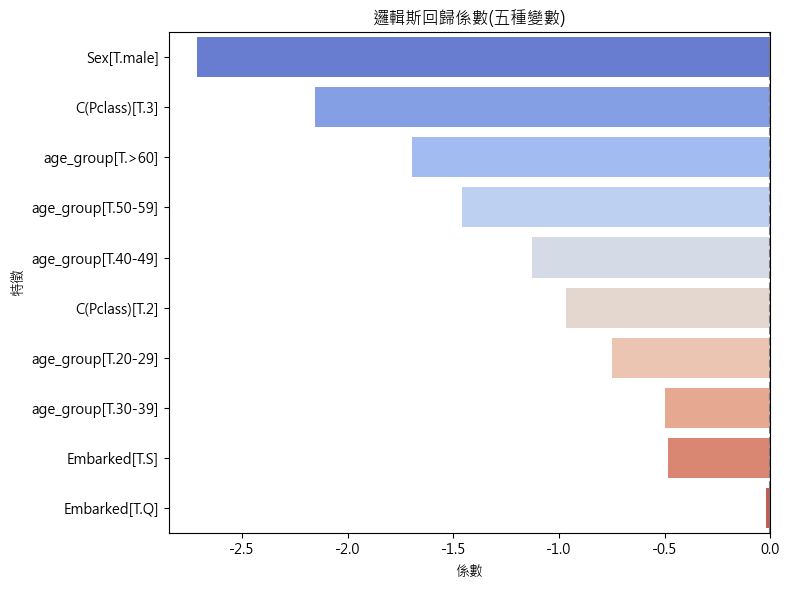

In [88]:
#五種變數的係數表
import seaborn as sns
import matplotlib.pyplot as plt

# 手動提取係數與變數名稱
# .params，抓取統計建模的係數，下面這行的[1:]是為了去掉Intercept才加上去的(僅顯示coef欄位的內容)

coef_df = all_model.params[1:]  
coef_df = coef_df.head(10).sort_values()

plt.figure(figsize=(8,6))
sns.barplot(x=coef_df.values, y=coef_df.index,palette='coolwarm')
plt.title('邏輯斯回歸係數(五種變數)')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('係數')
plt.ylabel('特徵')
plt.tight_layout()
plt.savefig('邏輯斯回歸係數(五種變數)',dpi = 300)
plt.show()

In [29]:
#邏輯斯回歸分析 - 預測建模(5個變數)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
#定義自變數、應變數
#先把非數值類的欄位做one-hot-encoded
cat_cols = ['Sex','Embarked','age_group']
df_all_encoded = pd.get_dummies(df_all, columns = cat_cols , drop_first = True)
df_train = df_all_encoded[df_all_encoded['is_train'] == 1].copy()
df_test = df_all_encoded[df_all_encoded['is_train'] == 0].copy()

one_hot_cols = [col for col in df_all_encoded.columns
               if col.startswith('Sex_') or col.startswith('Embarked_') or col.startswith('age_group_')]
final_features = one_hot_cols + ['Pclass','family_count']
x_train = df_train[final_features]
y_train = df_train['Survived']

x_test = df_test[final_features]
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(x_train,y_train)
#預測
y_pred = lr_model.predict(x_test)
y_prob = lr_model.predict_proba(x_test)[:,1]

df_test['Survived_Pred'] = y_pred 
df_test['Survived_Prob'] = y_prob

#評估模型
from sklearn.metrics import accuracy_score , classification_report
#預測訓練集
y_train_pred = lr_model.predict(x_train)
#準確率
print(f'訓練準確率 : {accuracy_score(y_train,y_train_pred):.4f}')
#更詳細的分類報告
print(classification_report(y_train,y_train_pred))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr_model,x_train,y_train,cv = 5 ,scoring = 'accuracy')
print(f'交叉驗證準確率 : {scores.mean():.4f}')

from sklearn.metrics import roc_auc_score
#預測訓練資料的機率
y_train_prob = lr_model.predict_proba(x_train)[:,1]
auc = roc_auc_score(y_train,y_train_prob)
print(f'訓練集 AUC 分數 : {auc:.4f}')

訓練準確率 : 0.8025
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       549
         1.0       0.77      0.69      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891

交叉驗證準確率 : 0.7924
訓練集 AUC 分數 : 0.8527


In [30]:
#邏輯斯回歸 - 預測建模(所有變數)
#評估模型
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
#定義自變數、應變數
#先把非數值類的欄位做one-hot-encoded
df_all_encoded = pd.get_dummies(df_all, drop_first = True)
df_all_encoded = df_all_encoded.fillna(0)
df_train = df_all_encoded[df_all_encoded['is_train'] == 1].copy()
df_test = df_all_encoded[df_all_encoded['is_train'] == 0].copy()

x_train = df_train.drop(columns = ['Survived','is_train'])
y_train = df_train['Survived']

x_test = df_test.drop(columns = ['Survived','is_train'])
from sklearn.linear_model import LogisticRegression
lr_models = LogisticRegression(max_iter = 2000,solver = 'liblinear')
lr_models.fit(x_train,y_train)
#預測
y_pred = lr_models.predict(x_test)
y_prob = lr_models.predict_proba(x_test)[:,1]

df_test['Survived_Pred'] = y_pred 
df_test['Survived_Prob'] = y_prob

from sklearn.metrics import accuracy_score , classification_report
#預測訓練集
y_train_pred = lr_models.predict(x_train)
#準確率
print(f'訓練準確率 : {accuracy_score(y_train,y_train_pred):.4f}')
#更詳細的分類報告
print(classification_report(y_train,y_train_pred))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr_models,x_train,y_train,cv = 5 ,scoring = 'accuracy')
print(f'交叉驗證準確率 : {scores.mean():.4f}')

from sklearn.metrics import roc_auc_score
#預測訓練資料的機率
y_train_prob = lr_models.predict_proba(x_train)[:,1]
auc = roc_auc_score(y_train,y_train_prob)
print(f'訓練集 AUC 分數 : {auc:.4f}')

訓練準確率 : 0.8934
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       549
         1.0       0.90      0.81      0.85       342

    accuracy                           0.89       891
   macro avg       0.90      0.88      0.88       891
weighted avg       0.89      0.89      0.89       891

交叉驗證準確率 : 0.8114
訓練集 AUC 分數 : 0.9602


In [31]:
df_train

,Survived,Pclass,Age,SibSp,Parch,Fare,is_train,family_count,Sex_male,Ticket_110413,...,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_>60
0,0.0,3,22.0,1,0,7.2500,1,1,True,False,...,False,False,False,False,True,True,False,False,False,False
1,1.0,1,38.0,1,0,71.2833,1,1,False,False,...,False,False,False,False,False,False,True,False,False,False
2,1.0,3,26.0,0,0,7.9250,1,0,False,False,...,False,False,False,False,True,True,False,False,False,False
3,1.0,1,35.0,1,0,53.1000,1,1,False,False,...,False,False,False,False,True,False,True,False,False,False
4,0.0,3,35.0,0,0,8.0500,1,0,True,False,...,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,27.0,0,0,13.0000,1,0,True,False,...,False,False,False,False,True,True,False,False,False,False
887,1.0,1,19.0,0,0,30.0000,1,0,False,False,...,False,False,False,False,True,False,False,False,False,False
888,0.0,3,28.0,1,2,23.4500,1,3,False,False,...,False,False,False,False,True,True,False,False,False,False
889,1.0,1,26.0,0,0,30.0000,1,0,True,False,...,False,False,False,False,False,True,False,False,False,False


Optimization terminated successfully.
         Current function value: 0.443923
         Iterations 6


C:\Users\rine2\AppData\Local\Temp\ipykernel_12324\4081325098.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top10_coefs.values, y = top10_coefs.index, palette='coolwarm')


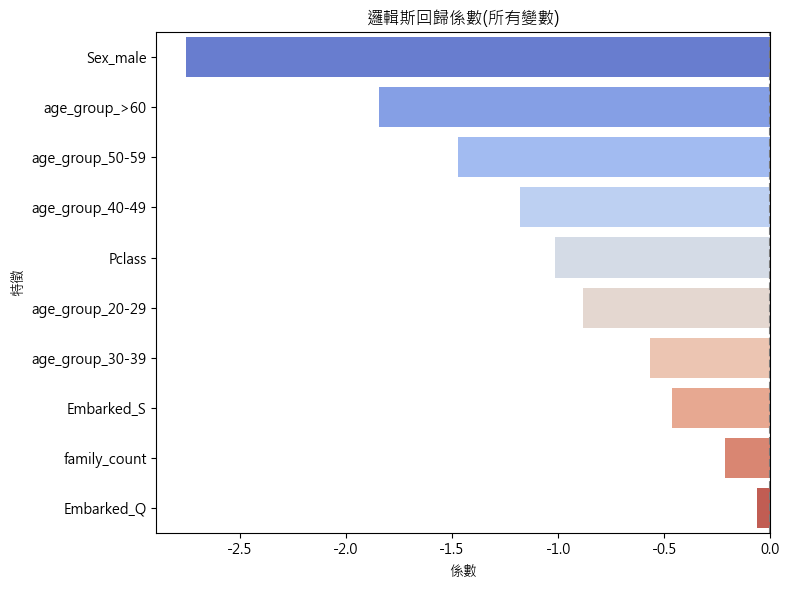

In [33]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 1. 去掉 ticket、cabin 這類高變異無結構欄位
df_train = df_all[df_all['is_train'] == 1].copy()
df_train_copy = df_train.drop(columns=['SibSp','Parch','is_train','Age','Cabin','Ticket']).copy()  # 視情況決定
# 2. 做 one-hot encoding
df_train_encoded = pd.get_dummies(df_train_copy, drop_first=True)

# 3. 正常建立模型
X = df_train_encoded.drop('Survived', axis=1)
y = df_train_encoded['Survived']
X = sm.add_constant(X)
X = X.astype(float)
model = sm.Logit(y, X)
result = model.fit()

# 抓出係數（不含截距）
coef_series = result.params.drop('const')

# 取絕對值前10名，保留原始係數
top10_index = coef_series.abs().sort_values(ascending=False).head(10).index
top10_coefs = coef_series.loc[top10_index].sort_values()

# 畫圖
plt.figure(figsize=(8, 6))
sns.barplot(x = top10_coefs.values, y = top10_coefs.index, palette='coolwarm')
plt.title("邏輯斯回歸係數(所有變數)")
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("係數")
plt.ylabel('特徵')
plt.tight_layout()
plt.savefig('邏輯斯回歸係數(所有變數)',dpi = 300)
plt.show()


In [34]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      879
Method:                           MLE   Df Model:                           11
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                  0.3334
Time:                        22:24:41   Log-Likelihood:                -395.54
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 5.297e-78
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.6882      0.522      8.983      0.000       3.665       5.711
Pclass             -1.0153      0.144     -7.042      0.000      -1.298      -0.733
Fare                0.0021      

In [35]:
coef = result.params
coef_df = pd.DataFrame({
    "Variable": coef.index,
    "Coefficient": coef.values})
coef_df_sorted_abs = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
print(coef_df_sorted_abs)

           Variable  Coefficient
0             const     4.688208
4          Sex_male    -2.754810
11    age_group_>60    -1.843988
10  age_group_50-59    -1.471987
9   age_group_40-49    -1.179123
1            Pclass    -1.015278
7   age_group_20-29    -0.881919
8   age_group_30-39    -0.568801
6        Embarked_S    -0.461700
3      family_count    -0.214937
5        Embarked_Q    -0.061839
2              Fare     0.002138


訓練準確率： 0.8541
分類報告：
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.89       549
         1.0       0.86      0.75      0.80       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891

訓練 AUC： 1.0000
交叉驗證準確率 : 0.7924


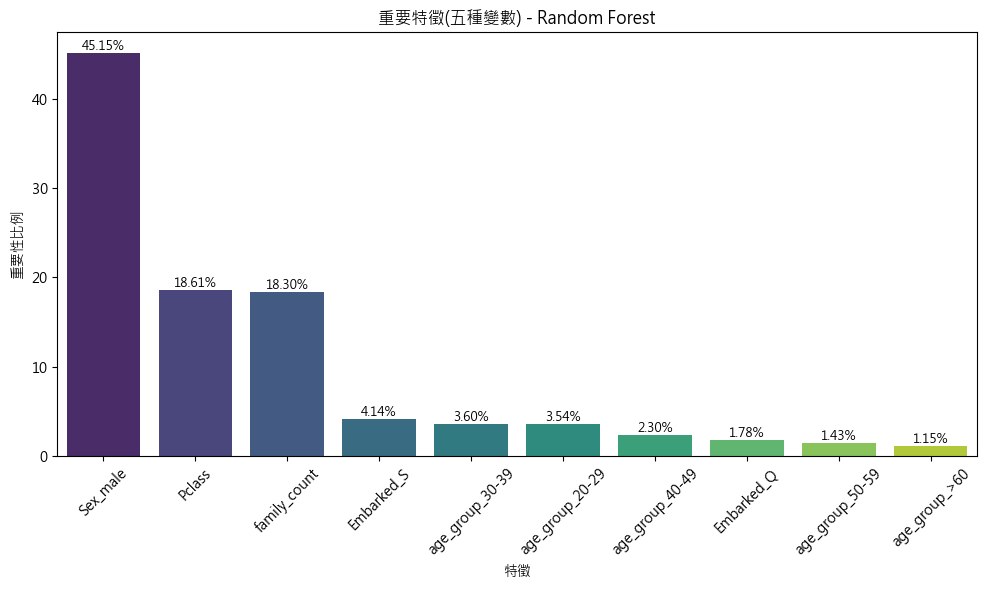

Random Forest：前3特徵佔總重要性比例 : 82.07%


In [82]:
#隨機森林 - 建模預測(五種變數)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ['Sex','Embarked','age_group']
df_all_encoded = pd.get_dummies(df_all, columns = cat_cols , drop_first = True)
df_train = df_all_encoded[df_all_encoded['is_train'] == 1].copy()
df_test = df_all_encoded[df_all_encoded['is_train'] == 0].copy()

one_hot_cols = [col for col in df_all_encoded.columns
               if col.startswith('Sex_') or col.startswith('Embarked_') or col.startswith('age_group_')]
final_features = one_hot_cols + ['Pclass','family_count']
x_train = df_train[final_features]
y_train = df_train['Survived']
x_test = df_test[final_features]

# randomforest 建模
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None , random_state=42)
rf_model.fit(x_train, y_train)

# 預測
y_pred_rf = rf_model.predict(x_test)
y_prob_rf = rf_model.predict_proba(x_test)[:, 1]

# 預測訓練集準確率
y_train_pred_rf = rf_model.predict(x_train)
y_train_prob_rf = rf_model.predict_proba(x_train)[:, 1]
auc_rf = roc_auc_score(y_train,y_train_prob_rf)

print(f'訓練準確率： {accuracy_score(y_train, y_train_pred_rf):.4f}')
print("分類報告：")
print(classification_report(y_train, y_train_pred_rf))
print(f'訓練 AUC： {auc:.4f}')

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, x_train, y_train, cv = 5 , scoring = 'accuracy')
print(f'交叉驗證準確率 : {scores.mean():.4f}')

#抓出特徵重要性
rf_importances = rf_model.feature_importances_
rf_features = pd.Series(rf_importances, index = x_train.columns).head(10).sort_values(ascending=False)
rf_importance = pd.DataFrame( {"Feature": x_train.columns,
                             "Importance": rf_importances}).sort_values("Importance", ascending=False)
rf_importance['Importance'] = (rf_importance['Importance']*100).round(2).astype(float)
# 畫圖：直式長條圖
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = rf_importance, x='Feature', y='Importance',hue='Feature', palette='viridis',dodge=False, legend=False)

# 顯示每個長條上的數值（小數點2位）
for bar in ax.patches:
    height = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    ax.text(x_pos, height, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

plt.title("重要特徵(五種變數) - Random Forest")
plt.xlabel('特徵')
plt.ylabel("重要性比例")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('重要特徵(五種變數) - Random Forest',dpi = 300)
plt.show()

# 分析前N個特徵貢獻度
def calc_importance_share(importances, top_n = 3):
    total = np.sum(importances)
    top_n_share = np.sum(np.sort(importances)[::-1][:top_n]) / total
    return round(top_n_share * 100, 2)

rf_top3_share = calc_importance_share(rf_importances, top_n = 3)
top3_importance_sum = rf_importance['Importance'].head(3).sum()
print(f"Random Forest：前3特徵佔總重要性比例 : {rf_top3_share}%")

In [92]:
x_test

,Pclass,Age,SibSp,Parch,Fare,family_count,Sex_male,Ticket_110413,Ticket_110465,Ticket_110469,...,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_>60
891,3,34.5,0,0,7.8292,0,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
892,3,47.0,1,0,7.0000,1,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
893,2,62.0,0,0,9.6875,0,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
894,3,27.0,0,0,8.6625,0,True,False,False,False,...,False,False,False,False,True,True,False,False,False,False
895,3,22.0,1,1,12.2875,2,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,28.0,0,0,8.0500,0,True,False,False,False,...,False,False,False,False,True,True,False,False,False,False
1305,1,39.0,0,0,108.9000,0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1306,3,38.5,0,0,7.2500,0,True,False,False,False,...,False,False,False,False,True,False,True,False,False,False
1307,3,28.0,0,0,8.0500,0,True,False,False,False,...,False,False,False,False,True,True,False,False,False,False


訓練準確率： 0.9955
分類報告：
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       549
         1.0       0.99      1.00      0.99       342

    accuracy                           1.00       891
   macro avg       0.99      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891

訓練 AUC： 1.0000
交叉驗證準確率 : 0.8216


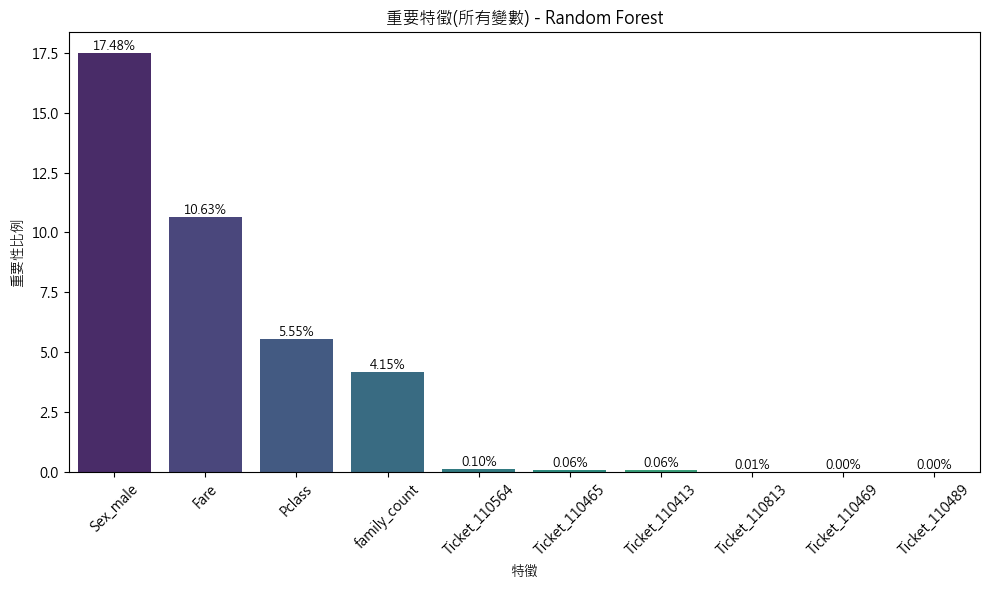

Random Forest：前3特徵佔總重要性比例 : 33.65%


In [94]:
#隨機森林 - 建模預測(所有變數)
df_all_encoded = pd.get_dummies(df_all, drop_first = True)
df_all_encoded = df_all_encoded.fillna(0)
df_train = df_all_encoded[df_all_encoded['is_train'] == 1].copy()
df_test = df_all_encoded[df_all_encoded['is_train'] == 0].copy()


x_train = df_train.drop(columns = ['Survived','is_train','SibSp','Parch','Age'])
y_train = df_train['Survived']
x_test = df_test.drop(columns = ['Survived','is_train','SibSp','Parch','Age'])

# randomforest 建模
rf_models = RandomForestClassifier(n_estimators=100, max_depth=None , random_state=42)
rf_models.fit(x_train, y_train)

# 預測
y_pred_rf = rf_models.predict(x_test)
y_prob_rf = rf_models.predict_proba(x_test)[:, 1]

# 預測訓練集準確率
y_train_pred_rf = rf_models.predict(x_train)
y_train_prob_rf = rf_models.predict_proba(x_train)[:, 1]
auc_rf = roc_auc_score(y_train,y_train_prob_rf)

print(f'訓練準確率： {accuracy_score(y_train, y_train_pred_rf):.4f}')
print("分類報告：")
print(classification_report(y_train, y_train_pred_rf))
print(f'訓練 AUC： {auc:.4f}')

#交叉驗證
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_models, x_train, y_train, cv = 5 , scoring = 'accuracy')
print(f'交叉驗證準確率 : {scores.mean():.4f}')

#抓出特徵重要性
rf_importances = rf_models.feature_importances_
rf_features = pd.Series(rf_importances, index = x_train.columns).head(10).sort_values(ascending=False)
rf_importance = pd.DataFrame( {"Feature": x_train.columns,
                             "Importance": rf_importances}).head(10).sort_values("Importance", ascending=False)
rf_importance['Importance'] = (rf_importance['Importance']*100).round(2).astype(float)
# 畫圖：直式長條圖
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = rf_importance, x='Feature', y='Importance',hue='Feature', palette='viridis',dodge=False, legend=False)

# 顯示每個長條上的數值（小數點2位）
for bar in ax.patches:
    height = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    ax.text(x_pos, height, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

plt.title("重要特徵(所有變數) - Random Forest")
plt.xlabel('特徵')
plt.ylabel("重要性比例")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('重要特徵(所有變數) - Random Forest',dpi = 300)
plt.show()

# 分析前N個特徵貢獻度
def calc_importance_share(importances, top_n = 3):
    total = np.sum(importances)
    top_n_share = np.sum(np.sort(importances)[::-1][:top_n]) / total
    return round(top_n_share * 100, 2)

rf_top3_share = calc_importance_share(rf_importances, top_n = 3)
top3_importance_sum = rf_importance['Importance'].head(3).sum()
print(f"Random Forest：前3特徵佔總重要性比例 : {rf_top3_share}%")

XGBoost 訓練準確率：0.8294
XGBoost 分類報告：
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       549
         1.0       0.86      0.66      0.75       342

    accuracy                           0.83       891
   macro avg       0.84      0.80      0.81       891
weighted avg       0.83      0.83      0.82       891

XGBoost ROC_AUC：0.8905
交叉驗證 AUC : 0.8003


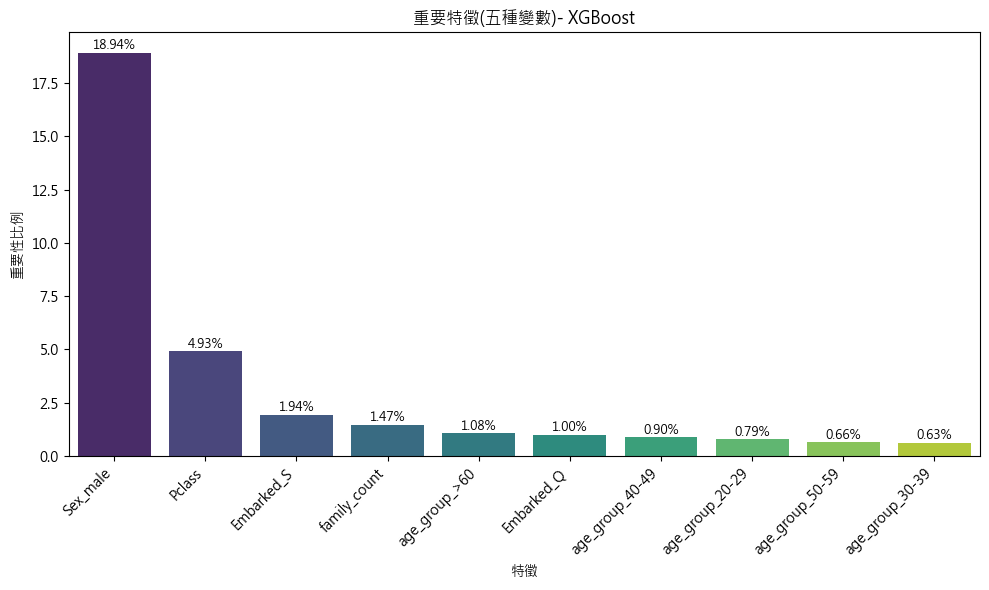

XGBoost前三名特徵占總重要性比例 : 25.81%


In [55]:
# XGBoost - 預測建模(五種變數)
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from xgboost import plot_importance

cat_cols = ['Sex','Embarked','age_group']
df_all_encoded = pd.get_dummies(df_all, columns = cat_cols , drop_first = True)
df_train = df_all_encoded[df_all_encoded['is_train'] == 1].copy()
df_test = df_all_encoded[df_all_encoded['is_train'] == 0].copy()

one_hot_cols = [col for col in df_all_encoded.columns
               if col.startswith('Sex_') or col.startswith('Embarked_') or col.startswith('age_group_')]
final_features = one_hot_cols + ['Pclass','family_count']
x_train = df_train[final_features]
y_train = df_train['Survived']
x_test = df_test[final_features]
# 建立 DMatrix（可選，但這裡我們照 sklearn API 寫法）
xgb_model = xgb.XGBClassifier( n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42)

xgb_model.fit(x_train, y_train)

# 預測測試資料
y_pred_xgb = xgb_model.predict(x_test)
y_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]

# 預測訓練資料
y_train_pred_xgb = xgb_model.predict(x_train)
y_train_prob_xgb = xgb_model.predict_proba(x_train)[:, 1]
auc_score = accuracy_score(y_train, y_train_pred_xgb)
roc_auc_score = roc_auc_score(y_train, y_train_prob_xgb)


# 評估結果
print(f"XGBoost 訓練準確率：{auc_score:.4f}")
print("XGBoost 分類報告：")
print(classification_report(y_train, y_train_pred_xgb))
print(f"XGBoost ROC_AUC：{roc_auc_score:.4f}")

#交叉驗證
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, x_train, y_train, cv = 5 , scoring = 'accuracy')
print(f'交叉驗證 AUC : {scores.mean():.4f}')


# 取得特徵重要性（以 gain 為準）
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': list(importance_dict.keys()),
                              'Importance': list(importance_dict.values())}).sort_values(by='Importance', ascending=False)

# 將 importance 四捨五入到小數點第二位
importance_df['Importance'] = importance_df['Importance'].round(2)

# 畫圖：直式長條圖
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=importance_df, x='Feature', y='Importance', hue='Feature', palette='viridis', dodge=False, legend=False)

# 顯示每個長條上的數值（小數點2位）
for bar in ax.patches:
    height = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    ax.text(x_pos, height + 0.01, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

plt.title("重要特徵(五種變數)- XGBoost")
plt.xticks(rotation=45, ha='right')
plt.xlabel('特徵')
plt.ylabel('重要性比例')
plt.tight_layout()
plt.savefig('重要特徵(五種變數) - XGBoost',dpi = 300)
plt.show()
top3_importance_sum = importance_df['Importance'].head(3).sum()
print(f'XGBoost前三名特徵占總重要性比例 : {top3_importance_sum:.2f}%')

In [62]:
importance_df

,Feature,Importance
0,Sex_male,18.94
8,Pclass,4.93
2,Embarked_S,1.94
9,family_count,1.47
7,age_group_>60,1.08
1,Embarked_Q,1.00
5,age_group_40-49,0.90
3,age_group_20-29,0.79
6,age_group_50-59,0.66
4,age_group_30-39,0.63


XGBoost 訓練準確率：0.8496
XGBoost 分類報告：
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       549
         1.0       0.86      0.73      0.79       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891

XGBoost ROC_AUC：0.9149
交叉驗證 AUC : 0.8047


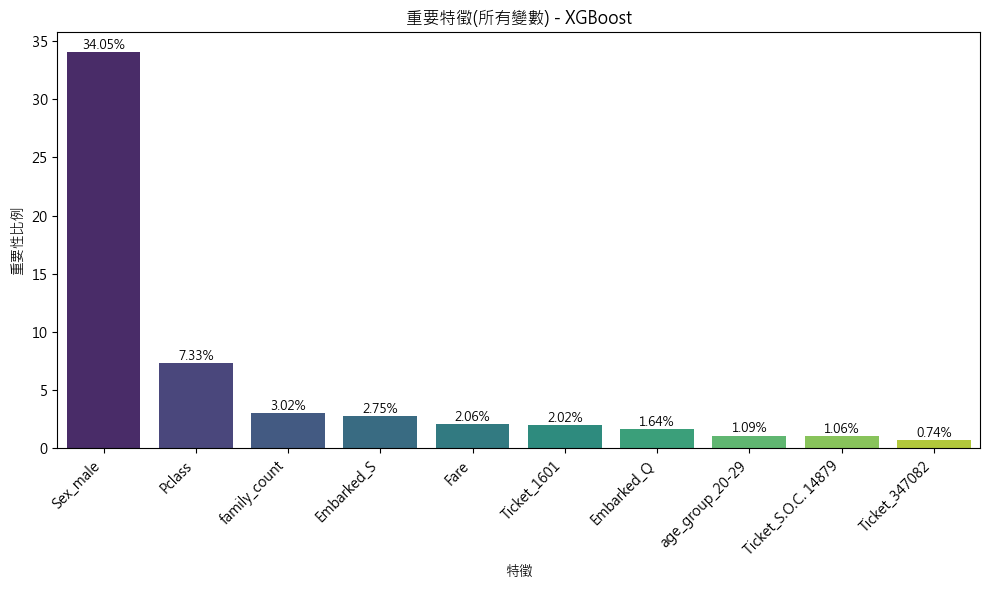

XGBoost前三名特徵占總重要性比例 : 44.40%


In [96]:
# XGBoost - 預測建模(所有變數)
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

df_all_encoded = pd.get_dummies(df_all, drop_first = True)
df_all_encoded = df_all_encoded.fillna(0)
df_train = df_all_encoded[df_all_encoded['is_train'] == 1].copy()
df_test = df_all_encoded[df_all_encoded['is_train'] == 0].copy()


x_train = df_train.drop(columns = ['Survived','is_train','SibSp','Parch','Age'])
y_train = df_train['Survived']
x_test = df_test.drop(columns = ['Survived','is_train','SibSp','Parch','Age'])

# 建立 DMatrix（可選，但這裡我們照 sklearn API 寫法）
xgb_models = xgb.XGBClassifier( n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42)

xgb_models.fit(x_train, y_train)

# 預測測試資料
y_pred_xgb = xgb_models.predict(x_test)
y_prob_xgb = xgb_models.predict_proba(x_test)[:, 1]

# 預測訓練資料
y_train_pred_xgb = xgb_models.predict(x_train)
y_train_prob_xgb = xgb_models.predict_proba(x_train)[:, 1]
auc_score = accuracy_score(y_train, y_train_pred_xgb)
roc_auc_score = roc_auc_score(y_train, y_train_prob_xgb)

# 評估結果
print(f"XGBoost 訓練準確率：{auc_score:.4f}")
print("XGBoost 分類報告：")
print(classification_report(y_train, y_train_pred_xgb))
print(f"XGBoost ROC_AUC：{roc_auc_score:.4f}")

#交叉驗證
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_models, x_train, y_train, cv = 5 , scoring = 'accuracy')
print(f'交叉驗證 AUC : {scores.mean():.4f}')

# 取得特徵重要性（以 gain 為準）
importance_dict = xgb_models.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': list(importance_dict.keys()),
                              'Importance': list(importance_dict.values())}).head(10).sort_values(by='Importance', ascending=False)

# 將 importance 四捨五入到小數點第二位
importance_df['Importance'] = importance_df['Importance'].round(2)

# 畫圖：直式長條圖
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=importance_df, x='Feature', y='Importance', hue='Feature', palette='viridis', dodge=False, legend=False)

# 顯示每個長條上的數值（小數點2位）
for bar in ax.patches:
    height = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    ax.text(x_pos, height + 0.01, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

plt.title("重要特徵(所有變數) - XGBoost")
plt.xticks(rotation=45, ha='right')
plt.xlabel('特徵')
plt.ylabel('重要性比例')
plt.tight_layout()
plt.savefig('重要特徵(所有變數) - XGBoost',dpi = 300)
plt.show()
top3_importance_sum = importance_df['Importance'].head(3).sum()
print(f'XGBoost前三名特徵占總重要性比例 : {top3_importance_sum:.2f}%')